In [5]:
%load_ext autoreload

In [6]:
%autoreload 2
import matplotlib.pyplot as plt
import mne
import numpy as np
import os
import pandas as pd
import re
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from tqdm.auto import tqdm

# Load Data

In [7]:
dt = 0.01
subject_id = 'SC4001'
# subject_id = 'SC4401'
# subject_id = 'SC4591'
# subject_id = 'ST7011'

all_data_dir = os.path.join("/om/user/eisenaj/datasets/sleep/sleep-edf-database")

In [8]:
if subject_id[1] == 'C':
    data_folder = os.path.join(all_data_dir, 'sleep-cassette')
else: # subject_id[1] == 'T'
    data_folder = os.path.join(all_data_dir, 'sleep-telemetry')

eeg_regex = re.compile(f"{subject_id}" + ".{2}-PSG.edf")
hypnogram_regex = re.compile(f"{subject_id}" + ".{2}-Hypnogram.edf")

eeg_path = None
hypnogram_path = None
for file_name in os.listdir(data_folder):
    if eeg_regex.match(file_name):
        eeg_path = os.path.join(data_folder, file_name)
    elif hypnogram_regex.match(file_name):
        hypnogram_path = os.path.join(data_folder, file_name)

if eeg_path is None or hypnogram_path is None:
    print(f"Failed to find data for subject ID {subject_id}")

eeg = mne.io.read_raw_edf(eeg_path)
eeg_df = eeg.to_data_frame()
hypnogram = mne.read_annotations(hypnogram_path)
hypnogram_df = hypnogram.to_data_frame()

Extracting EDF parameters from /om/user/eisenaj/datasets/sleep/sleep-edf-database/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [9]:
eeg

<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~12 kB, data not loaded>

In [289]:
start_time = 0
hypnogram_df['sleep_stage'] = [None]*len(hypnogram_df)
hypnogram_df['start_time'] = [None]*len(hypnogram_df)
hypnogram_df['end_time'] = [None]*len(hypnogram_df)
for i, row in hypnogram_df.iterrows():
    hypnogram_df.loc[i, 'sleep_stage'] = row.description[-1]
    hypnogram_df.loc[i, 'start_time'] = start_time
    hypnogram_df.loc[i, 'end_time'] = start_time + row.duration
    start_time += row.duration

In [290]:
eeg_df['sleep_stage'] = [None]*len(eeg_df)
place_in_session = 0
for i, row in tqdm(hypnogram_df.iterrows(), total=len(hypnogram_df)):
    if i == 0:
        indices = eeg_df.time <= place_in_session + int(row.duration/0.001)
    else:
        indices = np.logical_and(eeg_df.time > place_in_session, eeg_df.time <= place_in_session + int(row.duration/0.001))
    eeg_df.loc[indices, 'sleep_stage'] = row.description[-1]
    place_in_session += int(row.duration/0.001)

  0%|          | 0/231 [00:00<?, ?it/s]

## Plot

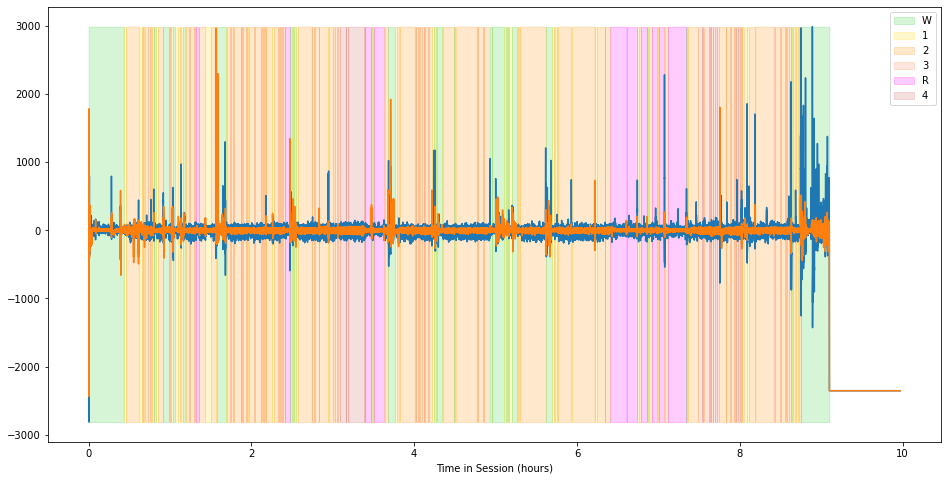

In [291]:
colors = {'W': 'limegreen', '1': 'gold', '2': 'darkorange', '3': 'coral', '4': 'indianred', 'R': 'magenta', '?': 'gray', 'e': 'gray'}

plt.figure(figsize=(16, 8))
time_vals = eeg_df.time*0.001/3600
plt.plot(time_vals, eeg_df['EEG Fpz-Cz'])
plt.plot(time_vals, eeg_df['EEG Pz-Oz'])
min_val = np.min([eeg_df['EEG Fpz-Cz'].min(), eeg_df['EEG Pz-Oz'].min()])
max_val = np.max([eeg_df['EEG Fpz-Cz'].max(), eeg_df['EEG Pz-Oz'].max()])
place_in_session = 0

seen = {}
for stage in colors.keys():
    seen[stage] = False
for _, row in hypnogram_df.iterrows():
    plt.fill_between(np.arange(row.start_time, row.end_time)/3600, min_val, max_val, color=colors[row.sleep_stage], label=row.sleep_stage if not seen[row.sleep_stage] else "", alpha=0.2)
    seen[row.sleep_stage] = True
#     print(place_in_session)
plt.xlabel("Time in Session (hours)")
# plt.xlim([8.5, 9])
plt.legend()
plt.show()

## VAR

In [1]:
def compute_VAR(window_data, unit_indices=None, PCA_dim=-1):
    if unit_indices is None:
        chunk = window_data
    else:
        chunk = window_data[:, unit_indices]
    k = chunk.shape[0]

    results = {}
    results['explained_variance'] = None
    if PCA_dim > 0:
        if PCA_dim < 2:
            raise ValueError(f"PCA dimension must be greater than 1; provided value was {PCA_dim}")
        pca = PCA(n_components=PCA_dim)
        chunk = pca.fit_transform(chunk)
        results['explained_variance'] = pca.explained_variance_ratio_
    
    model = VAR(chunk)
    VAR_results = model.fit(1)
    results['A_mat'] = VAR_results.coefs[0]
    results['A_mat_with_bias'] = VAR_results.params
    e,_ = np.linalg.eig(VAR_results.coefs[0])   
    results['eigs'] = e   
    results['criticality_inds'] = np.abs(e)

    results['sigma2_ML'] = np.linalg.norm(VAR_results.endog[1:] - (VAR_results.endog_lagged @ VAR_results.params), axis=1).sum()/(k - 2)
    results['AIC'] = k*np.log(results['sigma2_ML']) + 2
    results['sigma_norm'] = np.linalg.norm(VAR_results.sigma_u, ord=2)

    return results

In [301]:
all_eeg = np.zeros((len(eeg_df), 2))
all_eeg[:, 0] = eeg_df['EEG Fpz-Cz']
all_eeg[:, 1] = eeg_df['EEG Pz-Oz']

In [302]:
window = 10 # seconds
stride = window

num_windows = int(np.floor((all_eeg.shape[0]-int(window/dt))/int(stride/dt))+1)

all_results = []
for i in tqdm(range(num_windows)):
    start_ind = int(i*stride/dt)
    end_ind = int((i*stride + window)/dt)
    window_data = all_eeg[start_ind:end_ind]
    
    try:
        results = compute_VAR(window_data)
        results['start_time'] = i*stride
        results['start_time_ms'] = i*stride*1000
        results['start_ind'] = start_ind
        results['end_time'] = i*stride + window
        results['end_time_ms'] = (i*stride + window)*1000
        results['end_ind'] = end_ind
        all_results.append(results)
    except:
        pass
        # sometimes this doesn't work because the EEG isn't aligned at the beginning/end
VAR_results = pd.DataFrame(all_results)

  0%|          | 0/3590 [00:00<?, ?it/s]

## Plot VAR

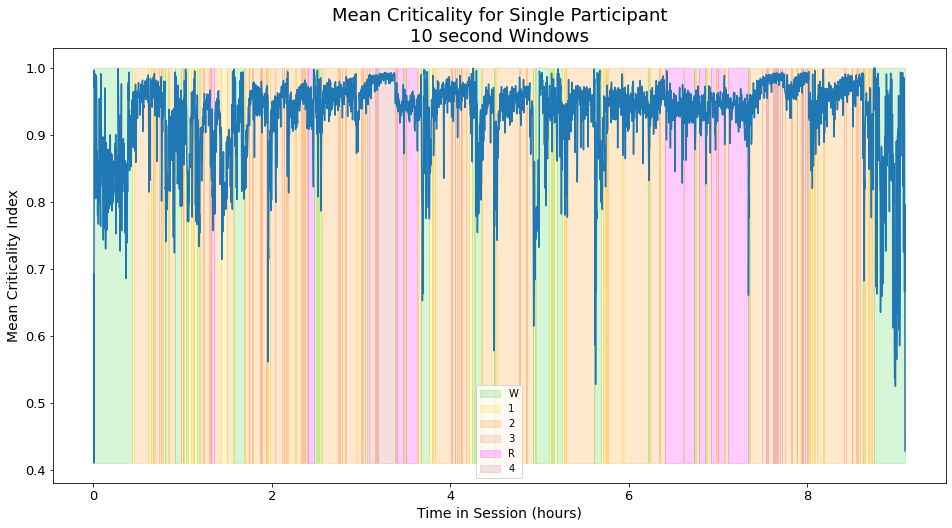

In [303]:
colors = {'W': 'limegreen', '1': 'gold', '2': 'darkorange', '3': 'coral', '4': 'indianred', 'R': 'magenta', '?': 'gray', 'e': 'gray'}

plt.figure(figsize=(16, 8))
time_vals = VAR_results.start_time/3600
# plt.plot(time_vals, eeg_df['EEG Fpz-Cz'])
# plt.plot(time_vals, eeg_df['EEG Pz-Oz'])
criticality_inds = VAR_results.criticality_inds.apply(lambda x: x.mean())
plt.plot(time_vals, criticality_inds)
min_val = criticality_inds.min()
max_val = criticality_inds.max()
place_in_session = 0

seen = {}
for stage in colors.keys():
    seen[stage] = False
for _, row in hypnogram_df.iterrows():
    plt.fill_between(np.arange(row.start_time, row.end_time)/3600, min_val, max_val, color=colors[row.sleep_stage], label=row.sleep_stage if not seen[row.sleep_stage] else "", alpha=0.2)
    seen[row.sleep_stage] = True
plt.xlabel("Time in Session (hours)", fontsize=14)
plt.ylabel("Mean Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt.title(f"Mean Criticality for Single Participant\n{window} second Windows", fontsize=18)
# plt.xlim([9, 10])
plt.legend()
plt.show()

## Label VAR Results

In [306]:
VAR_results['sleep_stage'] = [None]*len(VAR_results)
for i, row in tqdm(VAR_results.iterrows(), total=len(VAR_results)):
    sleep_stage_counts = {'W': 0, '1': 0, '2': 0, '3': 0, '4': 0, 'R': 0, '?': 0, 'e': 0}
    
    start_time_bool = hypnogram_df.start_time <= row.start_time
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(hypnogram_df) else len(hypnogram_df) - 1
    end_time_bool = hypnogram_df.end_time > row.end_time
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(hypnogram_df) - 1
    
    for row_ind in range(start_row, end_row + 1):
        row2 = hypnogram_df.iloc[row_ind]
        
        if row2.start_time <= row.start_time:
            start_in_chunk = row.start_time - row2.start_time
        else:
            start_in_chunk = 0
        
        if row2.end_time <= row.end_time:
            end_in_chunk = row2.duration
        else:
            end_in_chunk = row.end_time - row2.start_time
        
        sleep_stage_counts[row2.sleep_stage] += end_in_chunk - start_in_chunk
            
    VAR_results.loc[i, 'sleep_stage'] = max(sleep_stage_counts, key=sleep_stage_counts.get)

  0%|          | 0/3276 [00:00<?, ?it/s]

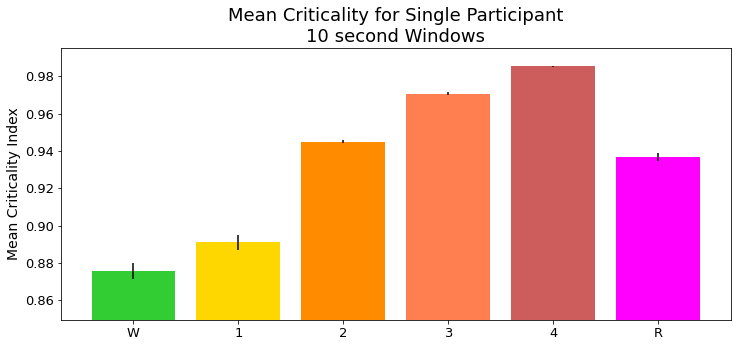

In [307]:
plt.figure(figsize=(12, 5))
mean_criticality_sleep_stage = []
std_error_sleep_stage = []
sleep_stage = []
sleep_stage_colors = []
for s in colors.keys():
    if s != '?' and s != 'e':
        if np.sum(VAR_results.sleep_stage == s) > 0:
            sleep_stage.append(s)
            all_inds = np.vstack(VAR_results[VAR_results.sleep_stage == s].criticality_inds.to_numpy()).flatten()
            mean_criticality_sleep_stage.append(all_inds.mean())
            std_error_sleep_stage.append(all_inds.std()/np.sqrt(len(all_inds)))
            sleep_stage_colors.append(colors[s])

plt.bar(sleep_stage, mean_criticality_sleep_stage, yerr=std_error_sleep_stage, color=sleep_stage_colors)
plt.ylim([np.min(mean_criticality_sleep_stage)*0.97, np.max(mean_criticality_sleep_stage)*1.01])
plt.ylabel("Mean Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt.title(f"Mean Criticality for Single Participant\n{window} second Windows", fontsize=18)
plt.show()